# Model fitting

In [105]:
#!/usr/bin/python
# by DBR 2/2017 #

%matplotlib inline  

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pyDOE
from scipy.stats import pearsonr,spearmanr,norm,lognorm
from all_models import *

#plt.style.use('seaborn-white')
plt.style.use('ggplot')

#upload data
prim_df = pd.DataFrame.from_csv('prim_df.csv')
prim_weeks = pd.DataFrame.from_csv('prim_weeks.csv')
ATI_df = pd.DataFrame.from_csv('ATI_df.csv')
ATI_weeks = pd.DataFrame.from_csv('ATI_weeks.csv')

ATI_list = [['Z09087','Z09106','Z09192','Z09204'],
            ['Z09144','Z08214','A11200','Z09196']] #8 good rebounds

#colors for plotting
cz=[['darkcyan','indigo','blue', 'royalblue'],
    ['indianred', 'darkred', 'salmon', 'red']]


In [4]:
#names of parameters to vary
param_names=[r'$\alpha_S$',
             r'$\delta_S$',
             r'$\beta$',
             r'$\tau$',
             r'$\delta_U$',
             r'$\delta_P$',
             r'$\kappa$',
             r'$\alpha_E$',
             r'$\delta_E$',
             r'$E_{50}$',
             r'$\omega$',
             r'$\pi$',
             r'$\gamma$',
             r'$S_0$',
             r'$E_0$']

In [33]:

#solvers for each model that return log viral load for fitting
def run1(tt,aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g,S0,E0):
    sol=odeint(model_1, [S0,U0,P0,E0,V0], tt, (aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g), mxstep=1000)
    logV=np.log10(sol[:,4]*1e3) #log viral load copies per mL
    return logV

def run2(tt,aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0):
    sol=odeint(model_2, [S0,U0,P0,E0,V0], tt, (aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    logV=np.log10(sol[:,4]*1e3) #log viral load copies per mL
    return logV

def run3(tt,aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0):
    sol=odeint(model_3, [S0,U0,P0,E0,V0], tt, (aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g), mxstep=1000)
    logV=np.log10(sol[:,4]*1e3) #log viral load copies per mL
    return logV

def run4(tt,aS,dS,Bt,tau,dI,k,aE,dE,w,p,g,S0,E0):
    sol=odeint(model_4, [S0,U0,P0,E0,V0], tt, (aS,dS,Bt,tau,dI,k,aE,dE,w,p,g), mxstep=1000)
    logV=np.log10(sol[:,4]*1e3) #log viral load copies per mL
    return logV

def run5(tt,aS,dS,Bt,tau,dI,k,P50,p,g,S0):
    sol=odeint(model_5, [S0,P0,V0], tt, (aS,dS,Bt,tau,dI,k,P50,p,g), mxstep=1000)
    logV=np.log10(sol[:,2]*1e3) #log viral load copies per mL
    return logV

def run6(tt,aS,dS,Bt,tau,dI,p,g,S0):
    sol=odeint(model_6, [S0,P0,V0], tt, (aS,dS,Bt,tau,dI,p,g), mxstep=1000)
    logV=np.log10(sol[:,2]*1e3) #log viral load copies per mL
    return logV


In [113]:
#try it for a single monkey!

aS = 100;   #constant growth rate of susceptibles [cells/uL/day]
dS = 0.3;   #susceptible death rate [1/day] 
Bt = 1e-4;  #infectivity [cells/virion-day]
tau= 0.05   #productively infected probability
dP = 1;     #productively infected death rate [1/day]
dU = 1;     #unproductively infected death rate [1/day]
dI = dP
k  = 10;    #immune cell killing rate [1/day]
aE = 0.001; #initial E cell concentration [cells/uL]
dE = 0.1;   #immune death rate [1/day]
E50 = 25;   #50 pct max E cell concentration [cells/uL]
w  = 0.01;  #immune cell multiplier [1/day]
p  = 5e4    #leak+burst viral production rate [virions/cell]
g  = 23     #viral clearance [1/day]

P50=10

#initial conditions that are always true regardless of model
U0=0      #no infected cells
V0=0.03   #start with 30 copies per mL
P0=0      #productively infected cells

#other initial conditions
S0 = aS/dS
E0 = aE/dE

guess1 = aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g,S0,E0
guess2 = aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0
guess3 = aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0
guess4 = aS,dS,Bt,tau,dI,k,aE,dE,w,p,g,S0,E0
guess5 = aS,dS,Bt,tau,dI,k,P50,p,g,S0
guess6 = aS,dS,Bt,tau,dI,p,g,S0

pz=np.array([len(guess1),len(guess2),len(guess3),len(guess4),len(guess5),len(guess6)])

po_list=[[],[],[],[],[],[]]; pc_list=[[],[],[],[],[],[]]; lk_list=[[],[],[],[],[],[]]; #intialize arrays
m_list=range(25) #choose which monkeys to fit
for m in m_list:

    t_data = prim_weeks.values[:,0]*7 #put in days scale
    V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data

    #model 1 fit
    po, pc = curve_fit(run1, t_data, V_data, p0=guess1, bounds=(0,np.inf), sigma=1, absolute_sigma=True, max_nfev=1e3) 
    aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g,S0,E0=po; 
    po_list[0].append(po); 
    pc_list[0].append(pc)
    V_sim = run1(t_data,aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g,S0,E0)
    lk_list[0].append(np.log(np.nanprod(norm.pdf(x=V_sim,loc=V_data,scale=1)))) #log likelihood

    #model 2 fit
    po, pc = curve_fit(run2, t_data, V_data, p0=guess2, bounds=(0,np.inf), sigma=1, absolute_sigma=True, max_nfev=1e3) 
    aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0=po; 
    po_list[1].append(po); 
    pc_list[1].append(pc)
    V_sim = run2(t_data,aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0)
    lk_list[1].append(np.log(np.nanprod(norm.pdf(x=V_sim,loc=V_data,scale=1)))) #log likelihood

    #model 3 fit
    po, pc = curve_fit(run3, t_data, V_data, p0=guess3, bounds=(0,np.inf), sigma=1, absolute_sigma=True, max_nfev=1e3) 
    aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0=po; 
    po_list[2].append(po); 
    pc_list[2].append(pc)
    V_sim = run3(t_data,aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0)
    lk_list[2].append(np.log(np.nanprod(norm.pdf(x=V_sim,loc=V_data,scale=1)))) #log likelihood

    #model 4 fit
    po, pc = curve_fit(run4, t_data, V_data, p0=guess4, bounds=(0,np.inf), sigma=1, absolute_sigma=True, max_nfev=1e3) 
    aS,dS,Bt,tau,dI,k,aE,dE,w,p,g,S0,E0=po; 
    po_list[3].append(po); 
    pc_list[3].append(pc)
    V_sim = run4(t_data,aS,dS,Bt,tau,dI,k,aE,dE,w,p,g,S0,E0)
    lk_list[3].append(np.log(np.nanprod(norm.pdf(x=V_sim,loc=V_data,scale=1)))) #log likelihood

    #model 5 fit
    po, pc = curve_fit(run5, t_data, V_data, p0=guess5, bounds=(0,np.inf), sigma=1, absolute_sigma=True, max_nfev=1e3) 
    aS,dS,Bt,tau,dI,k,P50,p,g,S0=po; 
    po_list[4].append(po); 
    pc_list[4].append(pc)
    V_sim = run5(t_data,aS,dS,Bt,tau,dI,k,P50,p,g,S0)
    lk_list[4].append(np.log(np.nanprod(norm.pdf(x=V_sim,loc=V_data,scale=1)))) #log likelihood

    #model 6 fit
    po, pc = curve_fit(run6, t_data, V_data, p0=guess6, bounds=(0,np.inf), sigma=1, absolute_sigma=True, max_nfev=1e3) 
    aS,dS,Bt,tau,dI,p,g,S0=po; 
    po_list[5].append(po); 
    pc_list[5].append(pc)
    V_sim = run6(t_data,aS,dS,Bt,tau,dI,p,g,S0)
    lk_list[5].append(np.log(np.nanprod(norm.pdf(x=V_sim,loc=V_data,scale=1)))) #log likelihood


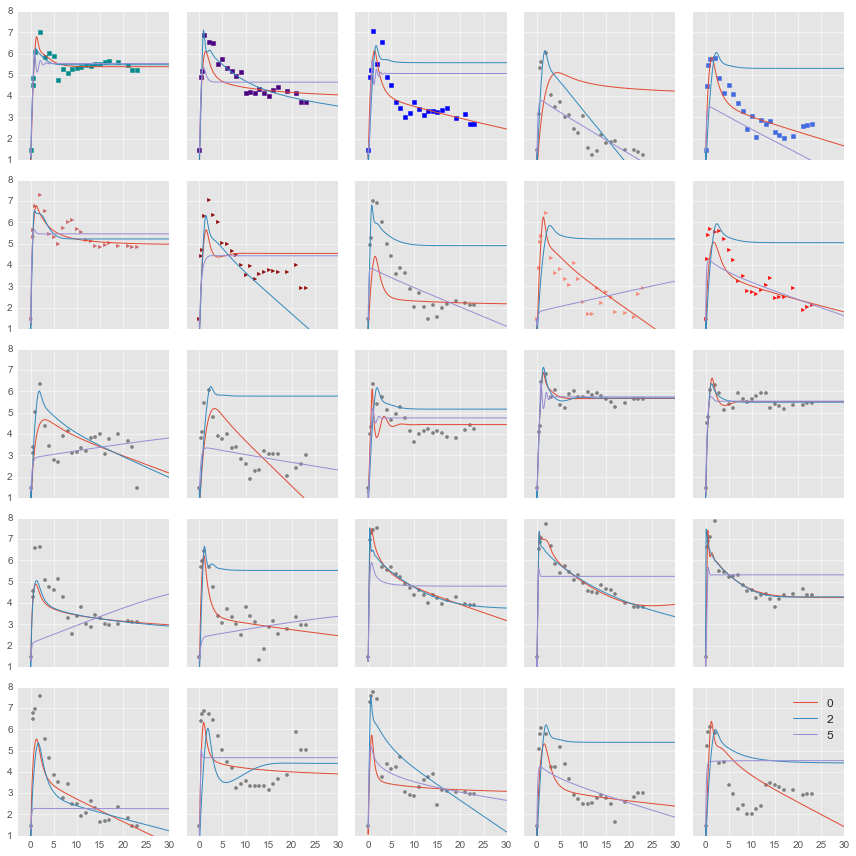

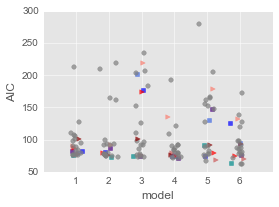

In [121]:
#now plot viral load fits

# The cheat sheet is as follows:
# 
# 1. complete
# 2. same natural death rate U and P
# 3. E doesn't see U cells
# 4. E does not saturate (back to E seeing U, and remains true henceforth)
# 5. simplified E formulation
# 6. no E at all
#
modelz=[0,2,5]
Vs=[[],[],[],[],[],[]]
fig,axarr = plt.subplots(5,5,sharex=True,sharey=True,figsize=(12,12),dpi=600)
fig2=plt.figure(figsize=(4,3),dpi=600)
ax2=fig2.add_subplot(111)
cind=0; tind=0
tt=np.linspace(0,30*7,1e4)
for m in m_list:
    if prim_df.keys()[m] in ATI_list[0]:
        markz='s'
        color=cz[0][cind]
        cind+=1
    elif prim_df.keys()[m] in ATI_list[1]:
        markz='>'
        color=cz[1][tind]
        tind+=1
    else:
        markz='o'
        color='gray'
    
    t_data = prim_weeks.values[:,0]*7 #put in days scale
    V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data

    aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g,S0,E0=po_list[0][m]
    Vs[0] = run1(tt,aS,dS,Bt,tau,dU,dP,k,aE,dE,E50,w,p,g,S0,E0)
    
    aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0=po_list[1][m]
    Vs[1] = run2(tt,aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0)
    
    aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0=po_list[2][m]
    Vs[2] = run3(tt,aS,dS,Bt,tau,dI,k,aE,dE,E50,w,p,g,S0,E0)

    aS,dS,Bt,tau,dI,k,aE,dE,w,p,g,S0,E0=po_list[3][m]
    Vs[3] = run4(tt,aS,dS,Bt,tau,dI,k,aE,dE,w,p,g,S0,E0)

    aS,dS,Bt,tau,dI,k,P50,p,g,S0=po_list[4][m]
    Vs[4] = run5(tt,aS,dS,Bt,tau,dI,k,P50,p,g,S0)

    aS,dS,Bt,tau,dI,p,g,S0=po_list[5][m]
    Vs[5] = run6(tt,aS,dS,Bt,tau,dI,p,g,S0)

    ax=axarr[int(np.floor(m/5))][m-int(np.floor(m/5))*5]
    ax.scatter(t_data/7,V_data,color=color,alpha=1,s=10,marker=markz)
    for i in modelz:
        ax.plot(tt/7,Vs[i])#,color='black',linewidth=1)

    AIC=2*pz-2*np.array(lk_list)[:,m]
    ax2.scatter(np.arange(1,len(AIC)+1)+np.random.normal(0,0.1,[1,len(AIC)]),AIC,color=color,alpha=0.7,s=20,marker=markz)

ax.set_xlim([-3,30])
ax.set_ylim([1,8])
ax.legend([str(modelz[_]) for _ in range(len(modelz))])
fig.tight_layout()
fig.savefig('primaryfits.pdf')  # No warning now
    
ax2.set_xticks(range(1,7))
ax2.set_xlabel('model')
ax2.set_ylabel('AIC')

fig2.tight_layout()
fig2.savefig('AIC.pdf')  # No warning now


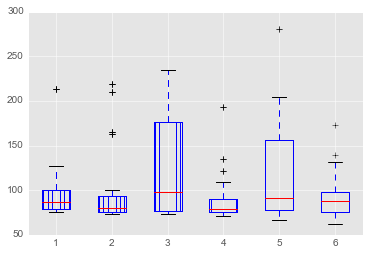

In [116]:
#boxplots for each model
databox=[]
for i in range(6):
    databox.append(2*pz[i]-2*np.array(lk_list)[i])
    plt.boxplot(databox)


In [ ]:
# primary infection data with covariance matrix!
covs=[]
for m in range(num_fits):
    
    V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    t_data = df.weeks[prim_df.iloc[:,m].index]*7 #put in days scale

    p_opt,p_cov = fitting_algorithm_cov(t_data,V_data,guess,guess_bounds)
            
    covs.append(p_cov)



In [ ]:
std_div_mean = np.sqrt(np.diag(np.mean(covs,0)))/np.mean(paramz_PI,0)    
for i in range(len(param_names)):
    #make the latex table for fit parameters
    print(param_names[i],'&', '%s' % float('%.2g' % std_div_mean[i]),r'\\')


In [ ]:

#show the fitting variance matrices
fig1,axarr = plt.subplots(5,5,sharex=True,sharey=True,figsize=(3,3),dpi=600)
for i in range(len(covs)):
    ax=axarr[int(np.floor(i/5))][i%5]
    mean_sq = np.transpose(np.matrix(paramz_PI[i]))*np.matrix(paramz_PI[i])#matrix of param values to normalize
    #ax.matshow(np.log10(np.abs(covs[i])))
    f=ax.matshow(np.log10(np.abs(covs[i])/mean_sq))
    f.set_clim([-1,7])
plt.yticks([])
plt.xticks([])
plt.tight_layout()
plt.gcf().savefig('all_covs.pdf')  # No warning now

fig2=plt.figure(figsize=(5,2),dpi=600)
mean_sq = np.transpose(np.matrix(np.mean(paramz_PI,0)))*np.matrix(np.mean(paramz_PI,0))#matrix of mean param values to normalize
plt.matshow(np.log10(np.mean(np.abs(covs),0)/mean_sq))
plt.yticks(range(9),param_names)
plt.xticks(range(9),param_names)
plt.colorbar()
#plt.tight_layout()
#plt.gcf().savefig('covariancematrix.pdf')  # No warning now
plt.gcf().savefig('labeled_cov.pdf')  # No warning now

plt.clim([-1,7])
#cbar = plt.colorbar( ticks=range(-3,10), orientation='horizontal')
#cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])  # horizontal colorbar


In [ ]:
#fit to R_0?
fig=plt.figure(figsize=(4,3),dpi=600)
cind=0; tind=0
for m in range(num_fits):
    if prim_df.keys()[m] in ATI_list and prim_df.keys()[m] in Contr:
        markz='s'
        color=cz[cind]
        cind+=1
    elif prim_df.keys()[m] in ATI_list and prim_df.keys()[m] in Trans:
        markz='>'
        color=cz[4+tind]
        tind+=1
    else:
        markz='o'
        color='gray'
    
    V_data = np.log10(prim_df.iloc[0:5,m].interpolate(method='linear',axis=0,limit=2)) #use log data
    t_data = df.weeks[prim_df.iloc[0:5,m].index]*7 #put in days scale
    
    R_0=2.3
    #plt.subplot(311)
    plt.scatter(t_data,V_data,color=color,marker=markz,alpha=0.5)
    plt.ylim([0,10])
    
plt.plot(t_data,(R_0-1)*t_data+np.log10(30),color='k')
plt.annotate('$V=V_0e^{\delta_P(\mathcal{R}_0-1)t}$', xy=(6.5,9), xytext=(6.5,9), fontsize=12)
plt.xlabel('Time $t$ (days)')
plt.ylabel('Viral load $V$ \n $\log_{10}$(copies/mL)')
plt.tight_layout()
plt.gcf().savefig('primary_R0.pdf')  # No warning now
    

In [ ]:
#plot between animal variance
fig=plt.figure(figsize=(4,3),dpi=600)

avg_log_V = np.mean(np.log10(prim_df),1) #use log data
std_log_V = np.std(np.log10(prim_df),1) #use log data

plt.plot(prim_weeks,avg_log_V)
plt.plot(prim_weeks,std_log_V)
#plt.plot(prim_weeks,np.log10(np.mean(prim_df,1)/np.std(prim_df,1)**2))

print(np.mean(std_log_V))

#plt.annotate('$V=V_0e^{\delta_P(\mathcal{R}_0-1)t}$', xy=(6.5,9), xytext=(6.5,9), fontsize=12)
plt.xlabel('Time $t$ (weeks)')
plt.ylabel('Viral load $V$ \n $\log_{10}$(copies/mL)')
plt.legend(['$\mu_{\log_{10}V}$','$\sigma_{\log_{10}V}$'],fontsize=16)
plt.tight_layout()
plt.gcf().savefig('primary_noise.pdf')  # No warning now


In [ ]:
#now plot T cells
fig,axarr = plt.subplots(5,5,sharex=True,sharey=True,figsize=(8,7),dpi=600)
cind=0; tind=0
tt=np.linspace(0,24*7,1e4)
print('CD8 fold-change','R_0')
for m in range(num_fits):
    if prim_df.keys()[m] in ATI_list and prim_df.keys()[m] in Contr:
        markz='s'
        color=cz[cind]
        cind+=1
    elif prim_df.keys()[m] in ATI_list and prim_df.keys()[m] in Trans:
        markz='>'
        color=cz[4+tind]
        tind+=1
    else:
        markz='o'
        color='gray'

    aS,dS,aE,dE,E50,k,w,S0,E0=paramz_PI[m,:]
    
    CD4s,CD8s = T_cell_calculate(tt,aS,dS,aE,dE,E50,k,w,aS/dS,E0)
    
    Bt=1e-4; #
    dI=1;    #
    tau=0.05  #Doitsh Cell 2010
    p=5e4
    g=23   #Shen PNAS 2007
    n=p/g
    
    Eeq=aE/dE
    
    print(max(CD8s)/E0,tau*Bt*n*aS/dS/dI-k*aE/dE/dI)
    
    #axarr[int(np.floor(m/5))][m-int(np.floor(m/5))*5].scatter(t_data/7,10**V_data,color=color,alpha=1,s=10,marker=markz)
    
    axarr[int(np.floor(m/5))][m-int(np.floor(m/5))*5].semilogy(tt/7,CD4s,color=color,linewidth=2)
    axarr[int(np.floor(m/5))][m-int(np.floor(m/5))*5].plot(tt/7,CD8s,color=color,linestyle='--',linewidth=2)
    
    #plt.xlim([-3,25])
    #plt.ylim([10,2e8])

axarr[4][2].set_xlabel('Time (weeks)')
axarr[2][0].set_ylabel('Cells per $\mu$L')

plt.legend(['all CD4+','cytolytic'],fontsize=8,loc=0)    
plt.tight_layout()
plt.gcf().savefig('primary_cells-peg.pdf')  # No warning now


In [ ]:
   
#actually plot from confidence in model to read table including stddev of parameters
fig,axarr = plt.subplots(3,3,sharey=False,sharex=True,figsize=(8,6),dpi=600)
for i in range(len(param_names)):
    ax=axarr[i-int(np.floor(i/3))*3][int(np.floor(i/3))]
        
    mup=np.mean(paramz_PI,0)[i]
    sigp=np.std(paramz_PI,0)[i]
    sigp2=np.sqrt(np.mean(errz_PI,0)[i]) #from covariance matrix

    rangez=np.linspace(mup/100,mup*100,1e4)
                             
    prob_param = norm.pdf(x=rangez,loc=mup,scale=sigp)
    

    #A common parametrization for a lognormal random variable Y is in terms of the mean, mu, and standard deviation, sigma, 
    #of the unique normally distributed random variable X such that exp(X) = Y. 
    #This parametrization corresponds to setting s = sigma and scale = exp(mu).
    #prob_param = lognorm.pdf(x=rangez, s=sigp, loc=mup, scale=np.exp(mup))

    
    
    prob_param2 = norm.pdf(x=rangez,loc=mup,scale=sigp2)

    #ax.semilogx(np.linspace(1/100,100,len(rangez)),prob_param/sum(prob_param))
    ax.semilogx(np.linspace(1/100,100,len(rangez)),prob_param2/sum(prob_param2))

    ax.set_title(param_names[i],fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=8)

    #make the latex table for fit parameters
    print(param_names[i],'&',
          '%s' % float('%.2g' % mup),
          '&','%s' % float('%.2g' % sigp),
          '&','%s' % float('%.2g' % sigp2)
          ,r'\\')

axarr[1][0].set_ylabel('probability of \n parameter value')
axarr[2][1].set_xlabel('parameter value \n (factor scaling initial)')
#axarr[2][2].legend(['$\sigma_p$','$\sigma_{p(cov)}$'],fontsize=12,loc=3)
#plt.xlim([1e-3,1e4])
plt.tight_layout()
plt.gcf().savefig('primary_variable_distributions-peg.pdf')  # No warning now


In [ ]:
#initialize the parameter arrays
paramz_ATI=np.zeros([len(ATI_list),len(param_names)]);
errz_ATI=np.zeros([len(ATI_list),len(param_names)]);


In [ ]:
#Modeling rebound infection data
fig,axarr = plt.subplots(2,4,sharex=True,sharey=True,figsize=(7,3),dpi=600)
#fit to all, or some
#for i in [2]:
for i in range(len(ATI_list)):
    
    V_data = np.log10(ATI_df[ATI_df.columns[i]].interpolate(method='linear',axis=0,limit=2).dropna(axis=0))
    
    t_temp = ATI_weeks_df[ATI_weeks_df.columns[i]]-ATI_weeks[ATI_weeks_df.columns[i]]
    
    t_data = t_temp[V_data.index]*7
    
    #aS,dS,aE,dE,E50,k,w,S0,E0=paramz_PI[i] #start at historic values
    
    aS = 100;  #
    dS = 0.3;   #susceptible death rate [1/day] 
    k  = 0.01
    w  = 0.01;  #immune cell multiplier [1/day]
    aE = 0.0001; #  
    E50= 250; #observed in data? order of magnitude estimate
    dE = 0.003;  #immune death rate [1/day]
    S0 = [100,100,110,210,1,1,1,1][i]   
    E0 = [100,100,90,212,1,1,1,1][i]   

    guess = aS ,dS  ,aE   ,dE    ,E50 ,k    ,w    ,S0 ,E0
    
    #much more generous bounds for E0 and S0
    u_b   = 1e3,3   ,0.00050,0.0500,1000,0.100,1.000,1e3,500
    l_b   = 10 ,0.03,0.00005,0.0003,100.,0.001,0.001,0  ,0
    guess_bounds = (l_b,u_b)
    
    guess_bounds = [tuple(np.array(guess)/10),tuple(np.array(guess)*10)]

    optimal,stdevz = fitting_algorithm(t_data,V_data,tuple(guess),guess_bounds) #perform fit
    
    paramz_ATI[i,:]=optimal; errz_ATI[i,:]=stdevz #add to array of parameters
    
#plot all now
for i in range(len(ATI_list)):
        
    V_data = np.log10(ATI_df[ATI_df.columns[i]].interpolate(method='linear',axis=0,limit=2).dropna(axis=0))
    
    t_temp = ATI_weeks_df[ATI_weeks_df.columns[i]]-ATI_weeks[ATI_weeks_df.columns[i]]
    
    t_data = t_temp[V_data.index]*7

    aS,dS,aE,dE,E50,k,w,S0,E0=paramz_ATI[i,:]

    tt=np.linspace(0,t_data.iloc[-1],1e4)
    logV=func_to_optimize(tt,aS,dS,aE,dE,E50,k,w,S0,E0) #optimize

    if ATI_df.columns[i] in Contr:
        markz='s'
    else:
        markz='>'

    axarr[int(np.floor(i/4))][i-int(np.floor(i/4))*4].scatter(t_data/7,10**V_data,color=cz[i],alpha=1,marker=markz,s=10)
    axarr[int(np.floor(i/4))][i-int(np.floor(i/4))*4].semilogy(tt/7,10**logV,'k',linewidth=1)

    plt.xlim([-3,25])
    plt.ylim([10,1e8])

plt.tight_layout()
plt.gcf().savefig('ATIfits-peg.pdf')  # No warning now

In [ ]:
#variable subplots

fig,axarr = plt.subplots(3,3,sharex=True,sharey=False,figsize=(8,6),dpi=600)
#plt.figure(figsize=(6,6),dpi=600)
nz=0.2
#variable_params = 

for i in range(len(param_names)):
    #plt.subplot(3,3,i+1)
    
    S=10 #marker size
    
    ax=axarr[i-int(np.floor(i/3))*3][int(np.floor(i/3))]

    cind=0; tind=0;
    for m in range(num_fits):

        if prim_df.keys()[m] in ATI_list and prim_df.keys()[m] in Contr:
            markz='s'
            color=cz[cind]
            cind+=1
            alz=1
        elif prim_df.keys()[m] in ATI_list and prim_df.keys()[m] in Trans:
            markz='>'
            color=cz[4+tind]
            tind+=1
            alz=1
        else:
            markz='o'
            color='gray'
            alz=0.5
        
        ax.scatter(1+np.random.uniform(low=-nz, high=nz),paramz_PI[m][i],color=color,alpha=alz,marker=markz,s=S)
    
    for j in range(4):
        ax.scatter(2+np.random.uniform(low=-nz, high=nz),paramz_ATI[j][i],color=cz[j],marker='s',s=S)
    for j in np.arange(4)+4:
        ax.scatter(3+np.random.uniform(low=-nz, high=nz),paramz_ATI[j][i],color=cz[j],marker='>',s=S)
    
    ax.set_title(param_names[i])
    #plt.ylim([l_b[i],u_b[i]])
    plt.yscale('log')
    #ax.set_xticks([1,2,3],['','',''])
    plt.xticks([1,2,3],['Primary','ATI \n ctl','ATI \n trans'])
    #ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.gcf().savefig('paramfits.pdf')  # No warning now

In [ ]:
#first find ratios of parameters to historic values
prat_ctl=np.zeros([4,len(param_names)])
prat_trs=np.zeros([4,len(param_names)])

for i in range(len(param_names)):   
    jC=0; jT=0
    for m in range(num_fits):
        if prim_df.keys()[m] in ATI_list:    
            if prim_df.keys()[m] in Contr:                
                prat_ctl[jC,i]=paramz_ATI[jC][i]/paramz_PI[m][i]
                jC+=1
            else:
                prat_trs[jT,i]=paramz_ATI[jT+4][i]/paramz_PI[m][i]
                jT+=1

#now calculate significantly different from 1 parameters
sig_yes_c=[]
sig_yes_t=[]
num_sigma=1

def moresig():
    for i in range(len(param_names)):
        mu_c = np.mean(prat_ctl[:,i])
        si_c = np.std(prat_ctl[:,i])

        if mu_c>1 and mu_c-num_sigma*si_c>1:
            sig_yes_c.append('*')
        if mu_c<1 and mu_c+num_sigma*si_c<1:
            sig_yes_c.append('*')
        else:
            sig_yes_c.append('')

        mu_t = np.mean(prat_trs[:,i])
        si_t = np.std(prat_trs[:,i])

        if mu_t>1 and mu_t-num_sigma*si_t>1:
            sig_yes_t.append('*')
        if mu_t<1 and mu_t+num_sigma*si_t<1:
            sig_yes_t.append('*')
        else:
            sig_yes_t.append('')

def simplesig():
    #just check if all greater or less than 1
    for i in range(len(param_names)):
        if (prat_ctl[:,i]<1).all() or (prat_ctl[:,i]>1).all():
            sig_yes_c.append('*')
        else:
            sig_yes_c.append('')

        if (prat_trs[:,i]<1).all() or (prat_trs[:,i]>1).all():
            sig_yes_t.append('*')
        else:
            sig_yes_t.append('')

simplesig()
#now make plots that show singnificant values
fig,axarr = plt.subplots(3,3,sharex=False,sharey=True,figsize=(7,5),dpi=600)
#plt.figure(figsize=(6,6),dpi=600)
for j in range(len(param_names)):
    
    ax=axarr[j-int(np.floor(j/3))*3][int(np.floor(j/3))]
    #plt.subplot(3,3,j+1)
        
    for i in range(4):
        ax.scatter(1+np.random.uniform(low=-nz, high=nz),prat_ctl[i,j],color=cz[i],marker='s',s=10)
        ax.scatter(2+np.random.uniform(low=-nz, high=nz),prat_trs[i,j],color=cz[i+4],marker='>',s=10)
    
    ax.annotate(str(param_names[j]), xy=(1.4,100), fontsize=16)
    #ax.set_title(str(param_names[j]),fontsize=12)
    ax.axhline(y=1,color='k')

    ax.set_yscale('log')
    ax.set_xlim([0.5,2.5])
    #ax.set_ylim([1e-2,1e3])
    
    xticklabz=['Ctl'+sig_yes_c[j],'Trs'+sig_yes_t[j]]
    ax.set_xticks([1,2])
    ax.set_xticklabels(xticklabz)

    #plt.tick_params(axis='both', which='major', labelsize=10)

plt.ylim([8e-3,1e3])
plt.tight_layout()
plt.gcf().savefig('param_ratios.pdf')  # No warning now


In [ ]:
#for each monkey, make a bar plot of its parameter changes

fig,axarr = plt.subplots(4,2,sharex=True,sharey=True,figsize=(8,4),dpi=600)

for i in range(4):
    axarr[i][0].bar(range(len(param_names)),prat_ctl[i],color=cz[i])
    axarr[i][1].bar(range(len(param_names)),prat_trs[i],color=cz[i+4])

    for j in range(2):
        axarr[i][j].axhline(y=1,color='k')
        axarr[i][j].tick_params(axis='both', which='major', labelsize=10)
        axarr[i][j].set_xticks(np.arange(len(param_names))+0.5)
        axarr[i][j].set_xticklabels(param_names)
    
    plt.ylim([0.1,100])
    plt.yscale('log')

plt.tight_layout()
plt.gcf().savefig('paramfits_bars-peg.pdf')  # No warning now

In [ ]:
#plotting violins for each variable from primary infection on a different subplot

#fig,axarr = plt.subplots(4,2,sharex=True,sharey=True,figsize=(8,4),dpi=600)
plt.figure(figsize=(8,6),dpi=600)

#variable_params = 
for i in range(len(param_names)):
    plt.subplot(3,3,i+1)
    
    plt.violinplot(np.array(paramz_PI)[:,i],showmedians=True)
    
    plt.title(param_names[i],fontsize=16)

    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=12)

    #plt.gca().axes.get_xaxis().set_visible(False)

plt.subplot(334)
plt.ylabel('Parameter value')
plt.subplot(338)
plt.xlabel('Normalized counts')

plt.tight_layout()
plt.gcf().savefig('paramfits_violins.pdf')  # No warning now